# Zalando - Exercise

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset — often used as the "Hello, World" of deep learning. As you know from the previous notebook, the MNIST dataset contains images of handwritten digits (0, 1, 2, etc.).

Now, we'll be using the Fashion MNIST, because it's a slightly more challenging problem than regular MNIST due to more complex patterns that have to be found.

As you'll see, the images we will be using, are still pretty basic (grayscale & small). In the next lesson, we will be tackling a CNN (Convolutional Neural Network), a network specifically designed for image classification. There, we will use more realistic (higher resolution, different size images, color) images.

<img src="./resources/fashion-mnist-sprite.png"  style="height: 500px"/>

This notebook is mainly intended as an exercise, so you will do the basic Fashion MNIST classification yourself, by using the previous notebook on the regular MNIST classification as your guideline. 

After the basic classification has been done, and we get some decent results, we'll switch gears again. 
We'll extend our capabilities a little bit further, by playing around with some of the parameters of our network (depth & width, learning rate, batch size), and even add a powerfull regularization layer (**Dropout**) to keep the awesome flexibility power of our network into check. That's when it becomes really interesting.



## 1. Import packages and classes

You can access the Fashion MNIST directly from TensorFlow. So first import all the packages needed for TensorFlow and Keras.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



## 2. Import the Fashion MNIST dataset

Import and load the Fashion MNIST data (`fashion_mnist`) directly from `keras.datasets`, into a train and test set.

In [2]:

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## 3. Explore the data (EDA)

Explore the format of the dataset before training the model. How many images are there in the training set. What size are the images?

In [3]:
# Print the shape of the training and test images & labels
print("Training Images Shape: ", train_images.shape)
print("Training Labels Shape: ", train_labels.shape)
print("Test Images Shape: ", test_images.shape)
print("Test Labels Shape: ", test_labels.shape)


Training Images Shape:  (60000, 28, 28)
Training Labels Shape:  (60000,)
Test Images Shape:  (10000, 28, 28)
Test Labels Shape:  (10000,)


Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


What are the different training and testing labels, and how many of each class are there in the dataset?

In [4]:
# Print the unique training/testing labels and counts
print("Unique Training Labels: ", np.unique(train_labels, return_counts=True))
print("Unique Test Labels: ", np.unique(test_labels, return_counts=True))


Unique Training Labels:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000],
      dtype=int64))
Unique Test Labels:  (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
      dtype=int64))


As you see, the y_train are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

<table>
    <tr><th>Label</th><th>Class</th></tr>
    <tr><td>0</td><td>T-shirt/top</td></tr>
    <tr><td>1</td><td>Trouser</td></tr>
    <tr><td>2</td><td>Pullover</td></tr>
    <tr><td>3</td><td>Dress</td></tr>
    <tr><td>4</td><td>Coat</td></tr>
    <tr><td>5</td><td>Sandal</td></tr>
    <tr><td>6</td><td>Shirt</td></tr>
    <tr><td>7</td><td>Sneaker</td></tr>
    <tr><td>8</td><td>Bag</td></tr>
    <tr><td>9</td><td>Ankle boot</td></tr>
</table>

Each image is mapped to a single label. Since the class names are not included in the dataset, we'll store them here to use later, when plotting the images:

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Quick printout of the first (head) and last 10 (tail) labels of train and test set, so we can check if they have a certain order to them, or if they are well shuffled

In [6]:
# Print the first and last 10 labels from train/test set
print("First 10 Training Labels: ", train_labels[:10])
print("Last 10 Training Labels: ", train_labels[-10:])

First 10 Training Labels:  [9 0 0 3 0 2 7 2 5 5]
Last 10 Training Labels:  [4 1 7 2 8 5 1 3 0 5]


We won't do a visual inspection of the distribution of the different labels in this exercise, nor print the a raw data sample in the form of a pandas dataframe. But you can, if you want to. We already know that a pixel is represented as a value between 0-255.

We will however do a visual plot of the first 10 images of each set, so we can get a feel of the data. We'll use a subplot of 4 rows, with 5 images on each row. For the label, we'll print out the actual class names, not just the class number (so use the class_names we created above)

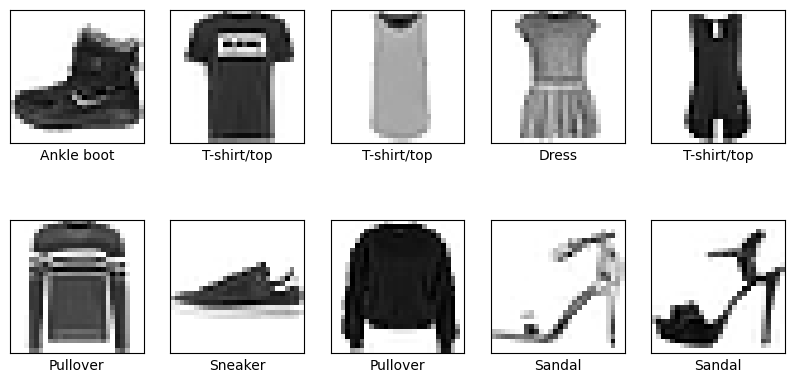

In [8]:
# Plot 10 images from each set in a subplot, and print the true label (not the numbers)

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

## 4. Preprocess the data & Build the model

We'll build a sequential model, including a rescaling layer to do our preprocessing. 

For now: use the same model architecture we used as for the regular MNIST data (because our data is very similar: also 28x28-shaped images, also in grayscale, also 10 output labels.

In [11]:
# Define your sequential model, with the different layers, including the preprocessing layers
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(28, 28)),
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])


d:\files\school\AI\02_AI - Graph Search Algorithms\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\files\school\AI\02_AI - Graph Search Algorithms\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## 6. Compile the model

Before the model is ready for training, it needs a few more settings. Compile the model with the same settings as the regular MNIST from previous notebook.

In [12]:
# Compile the model with the adam optimizer with lr of 0.001, sparse categorical loss, and accuracy as metric
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

## 7. Train the model

Now, it's time to train our model. Remember to save the training into a history object, so we can plot the training process later in our notebook, to check for over-or underfitting.

Again, we'll use the same settings as in our previous notebook: train for 20 epochs (total runs through our training set), use batches of 50 images (after each batch, update weights, and continu batch after batch until you've completed one entire epoch), and use a validation split of 20%.

In [13]:
# Train the model for 20 epochs, in batches of 50, and use a validation split of 20%. Remember to store the process in history object
history = model.fit(train_images, train_labels, epochs=20, batch_size=50, validation_split=0.2)


Epoch 1/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7577 - loss: 0.6982 - val_accuracy: 0.8518 - val_loss: 0.4250
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.8556 - loss: 0.4061 - val_accuracy: 0.8641 - val_loss: 0.3841
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.8727 - loss: 0.3592 - val_accuracy: 0.8684 - val_loss: 0.3700
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - accuracy: 0.8795 - loss: 0.3301 - val_accuracy: 0.8644 - val_loss: 0.3758
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.8897 - loss: 0.3023 - val_accuracy: 0.8737 - val_loss: 0.3585
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8940 - loss: 0.2899 - val_accuracy: 0.8799 - val_loss: 0.3322
Epoch 7/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.8981 - loss: 0.2788 - val_accuracy: 0.8850 - val_loss: 0.3236
Epoch 8/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9020 - loss: 0.2659 - val_ac

The model should reach a validation accuracy of around 88-89%.

Once the model is done training, we can take care of plotting the training process.
Just copy / paste the code to plot the loss and accuracy curves of our training (including the validation), but make a function of it (we need it a couple of times in this notebook)

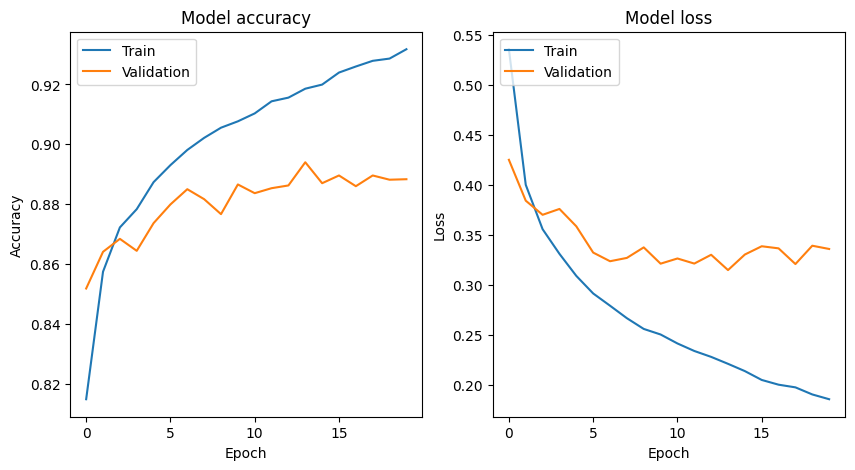

In [14]:
# Plot the training process

def plot_training(history):
    plt.figure(figsize=(10,5))

    # Plot training & validation accuracy values
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()



plot_training(history)

From the visualializations above, we can notice that with this architecture (and settings), around 6 or 11 epochs is a good estimator for our training job, because after that, with this network, our validation error starts to rise, and the gap with the training data also becomes bigger and bigger. 

This means that our model is honing in way too much on features specific to the training set, aka overfitting. If we wanted the best performance with this model, we should use the weights&biases of our model of epoch 6. But, we don't have them anymore! We only have the weights&biases from epoch20!?

So, we already detected a possible optimalisation for our network! 

In the next sections, we'll introduce some improvements, to try and get even better results. One of which, is to use **ModelCheckpoint**. This allows us to store the weights&biases from each epoch, and allows us to quickly load the best settings after we've trained for a bunch of epochs!

We'll be trying to improve our model, using the accuracy as our metric, because it gives a good overall view of our model. To get a more nuance picture of the performance, we could use the confusion matrix, and AUC metrics, but this is out of scope for this course.

Note: we optimize on the training and validation set here, because we want to make improvements on our model. **Never use the test set to optimize your network**. The test set is only meant to be used once, all the way at the end, when we think we have our very best network! In fact: in Kaggle competitions, it's often the case that the test set doesn't even have a label, because you have to predict those! 

## 8. Improvements - Tuning Hyper-parameters - architecture

Hyper-parameters are those settings of our network, that we have to choose, have to play around with. In contrast to the regular parameters, the knobs of our DJ board, the weights&biases, which are parameters that are learned.

In general, we have 2 types of hyper-parameters in a deep neural network: **hyper-parameters that deal with the architecture** of our network (how many layers, how many neurons per layer, what type of layers, what activation functions, etc), and those **hyper-parameters that deal with the learning process** itself (like the learning rate, the batch size, the number of epochs, the optimizer we use,...)

We'll start with some options you can try, to optimize your architecture. 

### Network Depth + different Activations 

We already know that we have a lot of options when designing a neural network. It's even considered more like an art-form, versus hard science. So, possible improvements usually come down to trial & error.

For instance: what happens if we add a couple **more fully-connected layers** to our model? How does that affect training and/or the model’s final performance? And, if we use **sigmoid activations versus ReLu activations** (the squishing functions of a neuron): does this have an effect?


### ModelCheckpoint + Dropout
Below, we'll design a new architecture with more layers, and some of them will use sigmoid activations. More layers, means more flexibility to detect even more complex patterns, but at the risk of overfitting. So, we'll also use the **ModelCheckpoint** as discussed above, so we can always revert back to the best epoch settings, while we fit for more epochs. Ofcourse, it's up to you to play around with these options, and maybe you can find an even better architecture?

But, there's also another way to keep the flexibility power of our network into check, and that's using a regularization technique, called **Dropout**. 
A dropout layer is a layer in a Neural Network that randomly drops out some of the neurons **during training** (only during training!). This means that some of the neurons are temporarily ignored or set to zero, and their connections to other neurons are also disabled. So, randomnly crippling small parts of your network. This prevents the network from relying too much on specific neurons or features, and forces it to learn more robust and generalizable representations. All neurons have to learn a little of all patterns, versus a couple of super-star neurons that capture almost the entire pattern. But, watch out: too much dropout and your network is severely impacted! So, use with care...

In [15]:
# First, let's printout our current model's architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,312 (1.16 MB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,542 (795.09 KB)

Okay, so our baseline model has around 101k parameters to train (knobs on our DJ board-weights&biases- that have to be adjusted to an optimal setting).

Next, let's redesign and compile a new model, called improv_model, with a couple of more layers (deeper network), and some layers that have more neurons (wider network). Let's also include some dropout, so we can counter the effects of overfitting:

In [21]:
from keras.callbacks import ModelCheckpoint

# Define your model as usual
improv_model = keras.Sequential([
    # Preprocessing: Add a Rescaling layer to rescale the pixel values to the [0, 1] range
    layers.Rescaling(1./255),
    # Input Layer: Add a Flattening layer to make 1-D vector of our 28x28 images
    layers.Flatten(input_shape=(28, 28)),
    # Hidden layer: Add a Dense layer, aka a fully or densely connected layer of 128 neurons, and let them use the 'ReLu'-squishing or activation function
    layers.Dense(128, activation='relu'),
    
    # Extra hidden layers
    layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25), # dropout layer applies to the layer above it 
    layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.25), # dropout layer applies to the layer above it 
    layers.Dense(256, activation='sigmoid'),
    layers.Dense(128, activation='sigmoid'),
    
    # Output layer: Add a Dense layer of 10 neurons (because we have 10 possible output labels), and link those neurons together in a group, via the 'softmax'-activation function
    layers.Dense(10, activation='softmax')
])
# Create a checkpoint callback
checkpoint = ModelCheckpoint("saved_models/checkpoints/weights_{epoch:02d}.weights.h5", save_weights_only=True, save_freq="epoch")
improv_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# Train your model with the callback: remember to store the training in an history object!
history = improv_model.fit(train_images, train_labels, epochs=20, batch_size=50, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20


d:\files\school\AI\02_AI - Graph Search Algorithms\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


960/960 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6615 - loss: 0.9529 - val_accuracy: 0.8388 - val_loss: 0.4457
Epoch 2/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8504 - loss: 0.4188 - val_accuracy: 0.8474 - val_loss: 0.4153
Epoch 3/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8718 - loss: 0.3641 - val_accuracy: 0.8635 - val_loss: 0.3710
Epoch 4/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8734 - loss: 0.3491 - val_accuracy: 0.8704 - val_loss: 0.3537
Epoch 5/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8861 - loss: 0.3157 - val_accuracy: 0.8742 - val_loss: 0.3443
Epoch 6/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8866 - loss: 0.3119 - val_accuracy: 0.8692 - val_loss: 0.3602
Epoch 7/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8933 - loss: 0.2960 - val_accuracy: 0.8802 - val_loss: 0.3267
Epoch 8/20
960/960 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8996 - loss: 0.2769 - val_accuracy: 0.8857 - val_

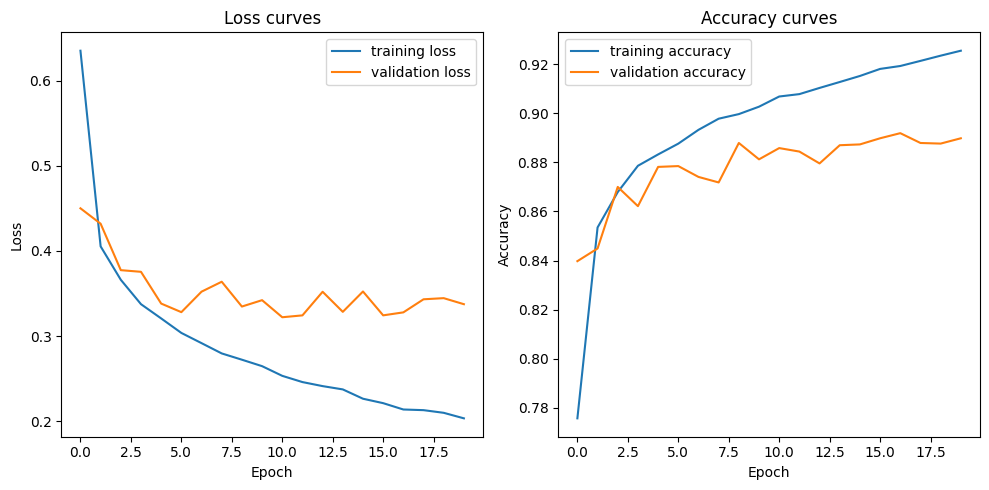

In [262]:
plot_training(history)

Looks like the performance of our new model, was best around epoch 12. But, than again: it isn't that much better as compared to our base model in the beginning. Yet, we added a lot more parameters to train (see below: 600k, versus 101k) - see below. So, our model is way more complex, but only has a similar performance. 

In [263]:
improv_model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_28 (Rescaling)    (50, 28, 28)              0         
                                                                 
 flatten_28 (Flatten)        (50, 784)                 0         
                                                                 
 dense_119 (Dense)           (50, 128)                 100480    
                                                                 
 dense_120 (Dense)           (50, 512)                 66048     
                                                                 
 dropout_23 (Dropout)        (50, 512)                 0         
                                                                 
 dense_121 (Dense)           (50, 512)                 262656    
                                                                 
 dropout_24 (Dropout)        (50, 512)               

Staying true to Occam's Razor (when comparing two models that have to predict the same thing, the simpler one is more likely to be the better one, generalizes better), our original model is probably the better choice, than our overdesigned improv_model.

But, maybe we can tweak some of the training-related hyper-parameter to get a better fit... Let's see.

So, let's load our improv_model from epoch 12, as our starting model (thanks to our checkpoints), and see if changing some of the hyper-parameters involved in the training-process can help us get a little better performance.

In [264]:
# Load the weights from epoch 12
improv_model.load_weights("saved_models/checkpoints/weights_12.tf")

## 9. Improvements - Tuning Hyper-parameters - training parameters

One of the **biggest impact hyper-parameters we can tune (once our architecture is set), is the learning rate**. But, it isn't that simple to select a good learning rate. 

It's out of scope for this course, but if you want to get top-notch performance (also use Transfer Learning, see later lesson): research learning rate schema's (especially the one cycle schema), and learning rate finders; which can help assist you in selecting a good learning rate(-range).


For now, just remember: **a learning rate that is too big, will be really bad for your performance because you constantly overshoot your optimal settings. And a learning rate too small, will take forever to train your network**. 

Usually a good approach, is to try and find a pretty good performing setting with the default learning rate of 0.001, and then 'cool down' your learning, so reduce your learning rate, so you can gently learn the last little details.

So, let's continu training our improv_model (with the settings from our previous epoch 12), but continu by using a learning rate of 0.0001 (1/10th of the original learning rate).

Another option you can also experiment with, is the **size of the batch**. The bigger the batch size, the more optimal our gradient calculations, aka our learning. But, there are also some drawbacks to using batches that are too big, besides the memory consumption (out of scope for this course). 
Usually, we can't make it too big, because an entire batch needs to fit into CPU/GPU RAM memory. And in real life, we often have higher resolution, and colored images. 

But, for demonstration purposes, we'll use a batch size of 500, with the smaller learning rate as discussed above. But again, you can definetely experiment with these settings. The larger batch size will definitely make the training process a lot smoother, because now the gradient is calculated on a larger dataset, and won't 'jump around' that much. 

In [265]:
# Only thing changed, is the learning rate, and the batch size
improv_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train your model with the callback: remember to store the training in an history object!
history = improv_model.fit(X_train, y_train, epochs=20, batch_size=500, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20


96/96 [==============================] - 4s 27ms/step - loss: 0.2085 - accuracy: 0.9227 - val_loss: 0.3083 - val_accuracy: 0.8945
Epoch 2/20
96/96 [==============================] - 2s 26ms/step - loss: 0.1954 - accuracy: 0.9262 - val_loss: 0.3086 - val_accuracy: 0.8953
Epoch 3/20
96/96 [==============================] - 2s 25ms/step - loss: 0.1894 - accuracy: 0.9299 - val_loss: 0.3124 - val_accuracy: 0.8957
Epoch 4/20
96/96 [==============================] - 2s 23ms/step - loss: 0.1867 - accuracy: 0.9301 - val_loss: 0.3146 - val_accuracy: 0.8941
Epoch 5/20
96/96 [==============================] - 2s 23ms/step - loss: 0.1840 - accuracy: 0.9311 - val_loss: 0.3174 - val_accuracy: 0.8954
Epoch 6/20
96/96 [==============================] - 2s 23ms/step - loss: 0.1826 - accuracy: 0.9317 - val_loss: 0.3180 - val_accuracy: 0.8958
Epoch 7/20
96/96 [==============================] - 2s 22ms/step - loss: 0.1804 - accuracy: 0.9329 - val_loss: 0.3220 - val_accuracy: 0.8952
Epoch 8/20
96/96 [======

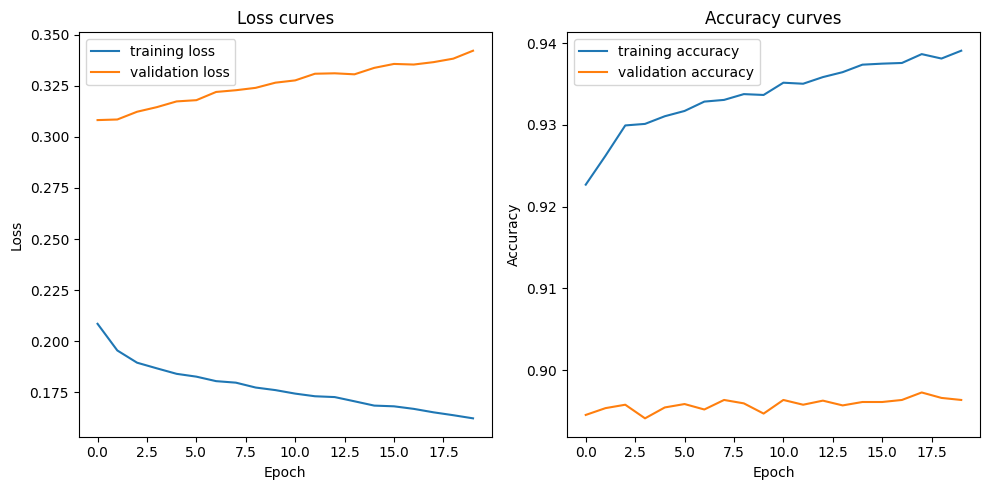

In [266]:
plot_training(history)

As you can see, these adjustments didn't really help. Our model keeps overfitting. So, to conclude...our model before all the bells and whistles, was probably the best one (until next lesson, when we employ a CNN network, or even the lesson after that when we'll dive into transfer learning).

So, we'll revert back to our original model instead of our improv_model to make our final predictions on the test set.


## 10. Make predictions on test set

We'll be using just the `evaluate`-method here, because we have the y_test (the test labels). When we would do a Kaggle competition, this would not be the case, and we would need the `predict`-method.

In [267]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy:', test_acc)


313/313 [==============================] - 1s 2ms/step - loss: 0.3880 - accuracy: 0.8750
Test accuracy: 0.875


# 11. Plot the most confused

To wrap things up, as a visual confirmation, that we've got 88% accuracy (which is pretty good), let's print out where our model went wrong, where it was most confused (it gave a high probability of item being of class A, but is was of class B for instance).

To do this, we need the `predict`-function. So, let's also save our results, into a csv file suited for a Kaggle competition upload.

313/313 [==============================] - 0s 1ms/step
[(5946, 5, 9, 0.99999976), (6061, 9, 5, 0.9999907), (2022, 9, 7, 0.9999753), (1300, 5, 8, 0.99996996), (5235, 8, 5, 0.99993455), (4693, 9, 7, 0.9998877), (3071, 9, 5, 0.99987257), (9917, 9, 7, 0.9997862), (2914, 9, 7, 0.99976677), (800, 9, 7, 0.9997472), (787, 3, 1, 0.9997079), (5082, 9, 5, 0.9995347), (9445, 8, 6, 0.9994861), (2965, 9, 7, 0.9993223), (324, 6, 4, 0.99923694), (9574, 6, 2, 0.99923587), (4742, 9, 5, 0.9992199), (9059, 1, 3, 0.9989911), (8972, 9, 7, 0.9988932), (5520, 9, 7, 0.9988745), (2856, 0, 6, 0.9987256), (6596, 8, 6, 0.99864155), (5316, 9, 7, 0.9985474), (5806, 0, 6, 0.9985129), (7189, 0, 6, 0.9984049), (8373, 2, 6, 0.99834394), (5334, 3, 0, 0.9983151), (2736, 9, 3, 0.998078), (8745, 0, 6, 0.99698013), (4166, 2, 4, 0.99681026), (4394, 8, 3, 0.9967775), (396, 6, 4, 0.9966228), (5210, 5, 7, 0.996463), (4040, 7, 5, 0.9963062), (5077, 7, 9, 0.9962114), (7761, 9, 7, 0.99596393), (5533, 3, 1, 0.9958916), (2599, 8, 0, 

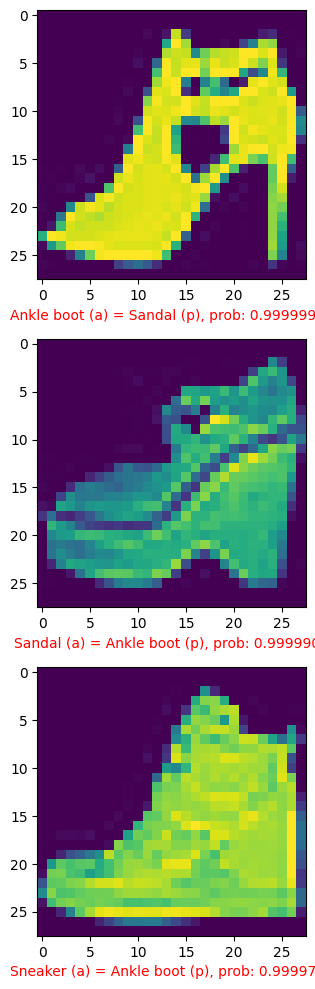

In [278]:
# First, let's generate the predictions for all the test images
predictions = model.predict(X_test)
# Next, we'll transform all the prediction into the winners (otherwise each prediction gives us the 10 probabilities, but we only need the winner, the one our network thinks it is)
pred = np.argmax(predictions, axis=1)
# Followed by finding all wrong predictions from test set
wrong_indices = np.where(pred != y_test)[0]

# Now we're in business!

# Create a list of tuples, containing the index, the prediction, the prediction probability, and the corresponding test label
wrong_predictions = [] 
for wrong_index in wrong_indices: 
    prediction = np.argmax(predictions[wrong_index]) 
    test_label = y_test[wrong_index] 
    prediction_prob = np.max(predictions[wrong_index]) 
    wrong_predictions.append((wrong_index, prediction, test_label, prediction_prob))
#print(wrong_predictions[0])

# Sort the list by prediction probability, descending order
wrong_predictions.sort(key=lambda x: x[3], reverse=True)

print(wrong_predictions)
print("Wrongest index:" + str(wrong_predictions[0][0]))
print("Wrongest prediction:" + str(wrong_predictions[0][1]))
print("Wrongest actual:" + str(wrong_predictions[0][2]))
print("Wrongest pred. prob:" + str(wrong_predictions[0][3]))

# Visualizing the top 3 most wrong predictions
top_wrong = 3
plt.figure(figsize=(10,10))
for i in range(top_wrong):
    plt.subplot(top_wrong, 1, i+1)
    plt.imshow(X_test[wrong_predictions[i][0]])
    label = plt.xlabel(str(class_names[wrong_predictions[i][2]]) + " (a) = " + str(class_names[wrong_predictions[i][1]]) + " (p), prob: " + str(wrong_predictions[i][3])).set_color("red")
plt.tight_layout()
plt.show()



It seems that identifying an Ankle boot from such low res images, is quite a challenge for our network!

Let's continue with the export to a CSV...

# 12. Export to csv

Since we just imported the test data via `(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()`, we don't have any real id numbers for the X_test. So, I'm just going to use the index als id

In [281]:
import pandas as pd

df = pd.DataFrame(data={"label": pred.flatten()})
df.index.name = "id" 
df.to_csv("predictions_MNIST_fashion.csv", index=True)